# Quantization of ResNet18

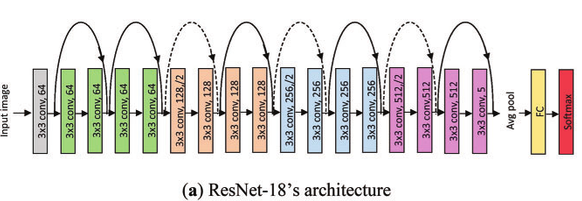

**Overview:** ResNet-18 is an 18-layer convolutional neural network (CNN) with residual connections to improve training of deep networks.



**Architecture:** 1 Conv2d, 4 residual blocks (Conv2d, BatchNorm2d, ReLU), 1 Linear layer. Total: ~11.7M parameters.

### CIFAR-10

Overview: 60,000 32x32 color images in 10 classes (e.g., airplane, dog). Split: 50,000 train, 10,000 test.

### key consideration while running the notebook

1. cpu only quantisation, gpu training

### documentation

https://docs.pytorch.org/docs/stable/quantization.html#quantization-api-summary

### netron

https://netron.app/

### quantisaiton modes

PyTorch provides three different modes of quantization:

1. Eager Mode Quantization : manual process, error prone, less automated, limited support for functions (torch.add)

2. FX Graph Mode Quantization (maintenance)

3. PyTorch 2 Export Quantization.

## ResNet18 training

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 855.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

# Load model
resnet18 = models.resnet18(weights=None)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    start_time = time.time()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    epoch_time = time.time() - start_time
    return running_loss / len(loader), acc, epoch_time

# Testing function
def test(model, loader, criterion, device):
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    return loss / len(loader), acc

# Run training
num_epochs = 20
best_acc = 0.0
for epoch in range(num_epochs):
    train_loss, train_acc, epoch_time = train(resnet18, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(resnet18, test_loader, criterion, device)
    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% | Epoch Time: {epoch_time:.2f}s")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(resnet18.state_dict(), "resnet18_cifar10_retrained50.pth")

# Final test
test_loss, test_acc = test(resnet18, test_loader, criterion, device)
print(f"Final FP32 Model | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

## Post Training Static Quantization, fx graph mode

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.ao.quantization
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Test function
def test(model, loader, criterion, device):
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    return loss / len(loader), acc

# Load the trained model
model_fp32 = models.resnet18(pretrained=False)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)
model_fp32.load_state_dict(torch.load("resnet18_cifar10_retrained20.pth", map_location=torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

# FX Graph Mode Quantization
from torch.ao.quantization import get_default_qconfig_mapping, quantize_fx
model_to_quantize = copy.deepcopy(model_fp32)
model_to_quantize.eval()
qconfig_mapping = get_default_qconfig_mapping("x86") #fbgemm, qnnpack
torch.backends.quantized.engine = 'x86'

# Prepare for quantization
example_inputs = (next(iter(test_loader))[0].to(device),)  # Single input tensor
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)

# Calibrate
def calibrate(model, loader, device, max_batches=50):
    model.eval()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= max_batches:
                break
            inputs = inputs.to(device)
            model(inputs)

calibrate(model_prepared, train_loader, device, max_batches=50)

# Convert to quantized model
quantized_model_int8 = quantize_fx.convert_fx(model_prepared)

# Define criterion
criterion = nn.CrossEntropyLoss()

# Test the quantized model
test_loss, test_acc = test(quantized_model_int8, test_loader, criterion, device)
print(f"Quantized Model | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Test the quantized model
test_loss, test_acc = test(model_fp32, test_loader, criterion, device)
print(f"Original model | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Save the quantized model
torch.save(quantized_model_int8.state_dict(), "resnet18_cifar10_PTSQ20.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Quantized Model | Test Loss: 0.4793, Test Acc: 84.11%
Original model | Test Loss: 0.4774, Test Acc: 84.03%


In [4]:
import os
print(f"FP32 Size: {os.path.getsize('resnet18_cifar10_retrained20.pth') / (1024**2):.2f} MB")
print(f"PTSQ Size: {os.path.getsize('resnet18_cifar10_PTSQ20.pth') / (1024**2):.2f} MB")

FP32 Size: 42.73 MB
PTSQ Size: 10.79 MB


## Static Quantization Aware Training (QAT)

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.ao.quantization
from torch.ao.quantization import get_default_qat_qconfig_mapping, quantize_fx
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    return running_loss / len(loader), acc

# Testing function
def test(model, loader, criterion, device):
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    return loss / len(loader), acc

# Load the trained FP32 model
model_fp32 = models.resnet18(pretrained=False)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)  # CIFAR-10 has 10 classes
model_fp32.load_state_dict(torch.load("resnet18_cifar10_retrained20.pth", map_location = torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

# Prepare for QAT
model_to_quantize = copy.deepcopy(model_fp32)
model_to_quantize.train()  # QAT requires training mode
qconfig_mapping = get_default_qat_qconfig_mapping("x86")
torch.backends.quantized.engine = 'x86'

# Example inputs for tracing
example_inputs = (next(iter(train_loader))[0].to(device),)

# Prepare the model for QAT
model_prepared = quantize_fx.prepare_qat_fx(model_to_quantize, qconfig_mapping, example_inputs)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_prepared.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)  # Lower LR for QAT
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Run QAT training
num_epochs = 5  # Fewer epochs for fine-tuning
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_prepared, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model_prepared, test_loader, criterion, device)
    scheduler.step()
    print(f"QAT Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Convert to quantized model
model_prepared.eval()  # Switch to eval mode for conversion
quantized_model_int8 = quantize_fx.convert_fx(model_prepared)

# Test the quantized model
test_loss, test_acc = test(quantized_model_int8, test_loader, criterion, device)
print(f"Quantized Model | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Save the quantized model
torch.save(quantized_model_int8.state_dict(), "resnet18_cifar10_qat20.pth")

## Dynamic Post Training Quantization

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.quantization
import time
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")  # For quantized model inference
print(f"Using device for FP32 operations: {device}")
print(f"Using device for quantized inference: {device_cpu}")

# Data transforms and loaders
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Testing function
def test(model, loader, criterion, device):
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    return loss / len(loader), acc

# Load the trained FP32 model
model_fp32 = models.resnet18(weights=None)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)
model_fp32.load_state_dict(torch.load("resnet18_cifar10.pth", map_location = torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

# Test FP32 model
criterion = nn.CrossEntropyLoss()
fp32_loss, fp32_acc = test(model_fp32, test_loader, criterion, device)
print(f"FP32 Model | Test Loss: {fp32_loss:.4f}, Test Acc: {fp32_acc:.2f}%")

# Apply Dynamic PTQ
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model_fp32.to(device_cpu),  # Move to CPU for quantization
    qconfig_spec={torch.nn.Linear},  # Quantize only nn.Linear layers
    dtype=torch.qint8
)
model_dynamic_quantized.eval()

# Test Dynamic PTQ model
dynamic_loss, dynamic_acc = test(model_dynamic_quantized, test_loader, criterion, device_cpu)
print(f"Dynamic PTQ Model | Test Loss: {dynamic_loss:.4f}, Test Acc: {dynamic_acc:.2f}%")

# Save the quantized model
torch.save(model_dynamic_quantized.state_dict(), "resnet18_cifar10_dynamic.pth")

# Measure model size
fp32_size = os.path.getsize("resnet18_cifar10.pth") / (1024 ** 2)
dynamic_size = os.path.getsize("resnet18_cifar10_dynamic.pth") / (1024 ** 2)
print(f"FP32 Model Size: {fp32_size:.2f} MB")
print(f"Dynamic PTQ Model Size: {dynamic_size:.2f} MB")

# Measure inference time
def measure_inference_time(model, loader, device, num_batches=10):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            start_time = time.time()
            model(inputs)
            total_time += time.time() - start_time
    return total_time / num_batches

dynamic_time = measure_inference_time(model_dynamic_quantized, test_loader, device_cpu)
print(f"Dynamic PTQ Inference Time: {dynamic_time:.4f} seconds/batch")

Using device for FP32 operations: cpu
Using device for quantized inference: cpu
FP32 Model | Test Loss: 1.0049, Test Acc: 64.26%
Dynamic PTQ Model | Test Loss: 1.0056, Test Acc: 64.31%
FP32 Model Size: 42.73 MB
Dynamic PTQ Model Size: 42.72 MB
Dynamic PTQ Inference Time: 0.3494 seconds/batch


In [34]:
import torch
import torchvision.models as models

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load FP32 model
model_fp32 = models.resnet18(weights=None)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)  # Modified for CIFAR-10
model_fp32.load_state_dict(torch.load("resnet18_cifar10.pth", torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

# Print FP32 model architecture
print("FP32 Model Architecture:")
print(model_fp32)

Using device: cpu
FP32 Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [36]:
import torch
import torch.nn as nn
import torchvision.models as models
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
print(f"Using device: {device}")

# Function to count nn.Linear layers
def count_linear_layers(model):
    linear_count = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, torch.ao.nn.quantized.Linear)):
            linear_count += 1
            print(f"Linear layer found: {name}, {module}")
    return linear_count

# Load FP32 model
model_fp32 = models.resnet18(weights=None)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)
model_fp32.load_state_dict(torch.load("resnet18_cifar10.pth", torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

# Count nn.Linear layers in FP32 model
print("FP32 Model:")
fp32_linear_count = count_linear_layers(model_fp32)
print(f"Total nn.Linear layers: {fp32_linear_count}")

Using device: cpu
FP32 Model:
Linear layer found: fc, Linear(in_features=512, out_features=10, bias=True)
Total nn.Linear layers: 1


In [38]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.ao.quantization
from torch.ao.quantization import QConfig, MinMaxObserver
from torch.ao.quantization import quantize_fx
import copy

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
print(f"Using device: {device}")

# Function to print all layers
def print_layers(model, model_name="Model"):
    print(f"\n{model_name} Layers:")
    print("-" * 50)
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only print leaf modules (individual layers)
            print(f"Layer: {name}, Type: {type(module).__name__}, Config: {module}")
    print("-" * 50)

# Load FP32 model
model_fp32 = models.resnet18(weights=None)
model_fp32.fc = nn.Linear(model_fp32.fc.in_features, 10)
model_fp32.load_state_dict(torch.load("resnet18_cifar10.pth", torch.device('cpu')))
model_fp32 = model_fp32.to(device)
model_fp32.eval()

Using device: cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# overview

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.ao.quantization
from torch.ao.quantization import get_default_qconfig_mapping, quantize_fx
import copy
import os
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
print(f"Using device for FP32 operations: {device}")
print(f"Using device for quantized inference: {device_cpu}")

# Data transforms and loaders
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Test function
def test(model, loader, criterion, device):
    model.eval()
    loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    return loss / len(loader), acc

# Function to count parameters and linear layers
def count_parameters_and_linear(model):
    total_params = sum(p.numel() for p in model.parameters())
    linear_count = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Linear, torch.ao.nn.quantized.Linear)):
            linear_count += 1
    return total_params, linear_count

# Measure inference time
def measure_inference_time(model, loader, device, num_batches=10):
    model.eval()
    total_time = 0.0
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches:
                break
            inputs = inputs.to(device)
            start_time = time.time()
            model(inputs)
            total_time += time.time() - start_time
    return total_time / num_batches

# Define .pth files
pth_files = {
    "Base FP32 (~64%)": "resnet18_cifar10.pth",
    "Base PTSQ (~64%)": "resnet18_cifar10_quantised.pth",
    "Base PTDQ (~64%)": "resnet18_cifar10_dynamic.pth",
    "Base QAT (~64%)": "resnet18_cifar10_qat.pth",
    "Retrained FP32 (~84%)": "resnet18_cifar10_retrained20.pth",
    "Retrained PTSQ (~84%)": "resnet18_cifar10_PTSQ20.pth",
    "Retrained PTDQ (~84%)": "resnet18_cifar10_dynamic.pth",
    #"Retrained QAT (~84%)": "resnet18_cifar10_qat_retrained_final.pth"
}

# Initialize base FP32 model
base_model = models.resnet18(weights=None)
base_model.fc = nn.Linear(base_model.fc.in_features, 10)

# Prepare quantized model template for PTSQ and QAT
model_to_quantize = copy.deepcopy(base_model)
model_to_quantize.eval()
qconfig_mapping = get_default_qconfig_mapping("x86")
torch.backends.quantized.engine = 'x86'
example_inputs = (next(iter(test_loader))[0].to(device_cpu),)
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
quantized_model_template = quantize_fx.convert_fx(model_prepared)

# Criterion
criterion = nn.CrossEntropyLoss()

# Evaluate each model
results = []
for model_name, pth_file in pth_files.items():
    print(f"\nEvaluating {model_name}...")
    if not os.path.exists(pth_file):
        print(f"File {pth_file} not found, skipping.")
        continue

    try:
        if "PTSQ" in model_name or "QAT" in model_name:
            # Load quantized model
            model = copy.deepcopy(quantized_model_template)
            model.load_state_dict(torch.load(pth_file, map_location=device_cpu))
            model = model.to(device_cpu)
        elif "PTDQ" in model_name:
            # Load PTDQ model
            model = copy.deepcopy(base_model)
            model.load_state_dict(torch.load(pth_file, map_location=device_cpu))
            model = torch.quantization.quantize_dynamic(
                model.to(device_cpu),
                qconfig_spec={torch.nn.Linear},
                dtype=torch.qint8
            )
        else:
            # Load FP32 model
            model = copy.deepcopy(base_model)
            model.load_state_dict(torch.load(pth_file, map_location=device))
            model = model.to(device)
        model.eval()

        # Test model
        test_loss, test_acc = test(model, test_loader, criterion, device_cpu if "PTSQ" in model_name or "QAT" in model_name or "PTDQ" in model_name else device)

        # Measure size
        model_size = os.path.getsize(pth_file) / (1024**2)

        # Measure latency
        latency = measure_inference_time(model, test_loader, device_cpu if "PTSQ" in model_name or "QAT" in model_name or "PTDQ" in model_name else device)

        # Count parameters and linear layers
        total_params, linear_count = count_parameters_and_linear(model)

        results.append({
            "Model": model_name,
            "Test Loss": test_loss,
            "Test Accuracy (%)": test_acc,
            "Model Size (MB)": model_size,
            "Latency (s/batch)": latency,
            "Total Parameters": total_params,
            "Linear Layers": linear_count
        })

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")

# Print results in a table
print("\nResults Summary:")
print("=" * 80)
print(f"{'Model':<25} {'Test Loss':<12} {'Test Acc (%)':<15} {'Size (MB)':<12} {'Latency (s/batch)':<18} {'Params':<12} {'Linear Layers':<12}")
print("-" * 80)
for result in results:
    print(f"{result['Model']:<25} {result['Test Loss']:<12.4f} {result['Test Accuracy (%)']:<15.2f} {result['Model Size (MB)']:<12.2f} {result['Latency (s/batch)']:<18.4f} {result['Total Parameters']:<12} {result['Linear Layers']:<12}")
print("=" * 80)

Using device for FP32 operations: cpu
Using device for quantized inference: cpu


/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:1318: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(



Evaluating Base FP32 (~64%)...

Evaluating Base PTSQ (~64%)...
File resnet18_cifar10_quantised.pth not found, skipping.

Evaluating Base PTDQ (~64%)...
Error evaluating Base PTDQ (~64%): Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.scale", "fc.zero_point", "fc._packed_params.dtype", "fc._packed_params._packed_params". 

Evaluating Base QAT (~64%)...

Evaluating Retrained FP32 (~84%)...

Evaluating Retrained PTSQ (~84%)...

Evaluating Retrained PTDQ (~84%)...
Error evaluating Retrained PTDQ (~84%): Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "fc.scale", "fc.zero_point", "fc._packed_params.dtype", "fc._packed_params._packed_params". 

Results Summary:
Model                     Test Loss    Test Acc (%)    Size (MB)    Latency (s/batch)  Params       Linear Layers
----------------------------------------------